<a href="https://colab.research.google.com/github/jiyewise/ML-with-PyTorch-Tutorials/blob/main/Optimizing_polynomial_with_Torch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Learning PyTorch with Examples: Optimizing Polynomial
앞에서 `torch.nn`, `autograd` 와 같은 개념들을 이미 한번 돌아보았기 때문에 여기서는 이 개념들을 간단한 예시로 복습하고자 한다. 여기서는 sin함수를 근사한 $ax^3 + bx^2 + cx + d$ 와 같은 3차원 polynomial의 계수를 optimization을 통해 찾아보고자 한다.


1. with `Torch.Tensor` and manual gradient descent
2. defining new `autograd `(with `torch.autograd.Function`)
3. `nn.Module` & without `optimizer`
4. `nn.Module` & with `optimizer`


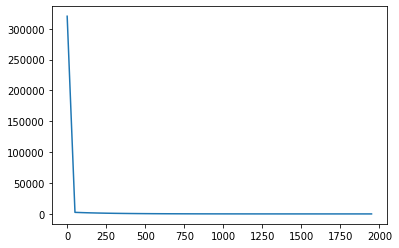

Loss: 10.573115348815918
Result: y = -0.038325466215610504 + 0.836235761642456 x + 0.006611780263483524 x^2 + -0.09041371941566467 x^3


In [12]:
# Example 1: Implementation with Torch.Tensor and manual gradient descent

import torch
import math
from matplotlib import pyplot as plt

dtype = torch.float
device = torch.device("cpu")
# device = torch.device("cuda:0")  # Uncomment this to run on GPU

"""
Create Tensors to hold input and outputs.
By default, requires_grad=False, which indicates that we do not need to
compute gradients with respect to these Tensors during the backward pass.
We do not have to compute gradients as the x and y values are for training, 
and they are not targeted for optimization
"""
x = torch.linspace(-math.pi, math.pi, 2000, device=device, dtype=dtype)
y = torch.sin(x)

"""
Create random Tensors for weights. For a third order polynomial, we need
4 weights: y = a + b x + c x^2 + d x^3
"""

a = torch.randn((), device=device, dtype=dtype, requires_grad=True)
b = torch.randn((), device=device, dtype=dtype, requires_grad=True)
c = torch.randn((), device=device, dtype=dtype, requires_grad=True)
d = torch.randn((), device=device, dtype=dtype, requires_grad=True)

learning_rate = 1e-6

# plot the result
loss_index = []
loss_y = []

for t in range(2000):
    # Forward pass: compute predicted y using operations on Tensors.
    y_pred = a + b * x + c * x ** 2 + d * x ** 3

    # Compute loss with y, which is the calculated sin value
    loss = (y_pred - y).pow(2).sum() # form of Tensor[1,]
    if t % 50 == 0:
        # print(t, loss.item())
        loss_index.append(t) 
        loss_y.append(loss.item()) #loss.item() changes into a scalar value

    loss.backward() # computing the gradients

    """
    Instead of using autograd,
    Manually update weights using gradient descent. Wrap in torch.no_grad()
    This is because weights have requires_grad=True, 
    but we don't need to track this in autograd in autograd.
    """

    with torch.no_grad():
        a -= learning_rate * a.grad
        b -= learning_rate * b.grad
        c -= learning_rate * c.grad
        d -= learning_rate * d.grad
        
        # if t % 100 == 99:
        #     print(f"Under optimization: a: {a} b: {b} c: {c} d: {d}")

        # Manually zero the gradients after updating weights
        a.grad = None
        b.grad = None
        c.grad = None
        d.grad = None

# plot and print the result
plt.plot(loss_index, loss_y)
plt.show()

print(f"Loss: {loss.item()}")
print(f'Result: y = {a.item()} + {b.item()} x + {c.item()} x^2 + {d.item()} x^3')

### Inheriting the `torch.autograd.Function`

By inheriting the `torch.autograd.Function` class, we can define the `forward` and `backward` functions as follows:

```Python
    @staticmethod
    def forward(ctx, input):
        """
        In the forward pass we receive a Tensor containing the input and return
        a Tensor containing the output. ctx is a context object that can be used
        to stash information for backward computation. You can cache arbitrary
        objects for use in the backward pass using the ctx.save_for_backward method.
        """
        ctx.save_for_backward(input)
        return 0.5 * (5 * input ** 3 - 3 * input)

    @staticmethod
    def backward(ctx, grad_output):
        """
        In the backward pass we receive a Tensor containing the gradient of the loss
        with respect to the output, and we need to compute the gradient of the loss
        with respect to the input.
        """
        input, = ctx.saved_tensors
        return grad_output * 1.5 * (5 * input ** 2 - 1)
```

As we are using a 3 degree polynomial,we define our model as $y=a+bP3(c+dx)$ instead of $y=a+bx+cx2+dx3$, where $P3(x)=12(5x3−3x)$ is the Legendre polynomial of degree three. The model and its gradient are defined in the `forward` and `backward` function, respectively.




In [13]:
import torch
import math


class LegendrePolynomial3(torch.autograd.Function):
    """
    We can implement our own custom autograd Functions by subclassing
    torch.autograd.Function and implementing the forward and backward passes
    which operate on Tensors.
    """

    @staticmethod
    def forward(ctx, input):
        """
        In the forward pass we receive a Tensor containing the input and return
        a Tensor containing the output. ctx is a context object that can be used
        to stash information for backward computation. You can cache arbitrary
        objects for use in the backward pass using the ctx.save_for_backward method.
        """
        ctx.save_for_backward(input)
        return 0.5 * (5 * input ** 3 - 3 * input)

    @staticmethod
    def backward(ctx, grad_output):
        """
        In the backward pass we receive a Tensor containing the gradient of the loss
        with respect to the output, and we need to compute the gradient of the loss
        with respect to the input.
        """
        input, = ctx.saved_tensors
        return grad_output * 1.5 * (5 * input ** 2 - 1)


dtype = torch.float
device = torch.device("cpu")
# device = torch.device("cuda:0")  # Uncomment this to run on GPU

x = torch.linspace(-math.pi, math.pi, 2000, device=device, dtype=dtype)
y = torch.sin(x)

"""
Create random Tensors for weights. For this example, we need
4 weights: y = a + b * P3(c + d * x), these weights need to be initialized
not too far from the correct result to ensure convergence.
Setting requires_grad=True indicates that we want to compute gradients with
respect to these Tensors during the backward pass.
"""

a = torch.full((), 0.0, device=device, dtype=dtype, requires_grad=True)
b = torch.full((), -1.0, device=device, dtype=dtype, requires_grad=True)
c = torch.full((), 0.0, device=device, dtype=dtype, requires_grad=True)
d = torch.full((), 0.3, device=device, dtype=dtype, requires_grad=True)

learning_rate = 5e-6
for t in range(2000):

    """
    To apply our Function, we use Function.apply method. We alias this as 'P3'.
    """
    # NOTE: not apply() as this is not "calling" the function
    P3 = LegendrePolynomial3.apply

    """
    Forward pass: compute predicted y using operations
    we compute P3 using our custom autograd operation.
    Compare this with the previous example, where 
    y_pred = a + b * x + c * x ** 2 + d * x ** 3
    """

    # same as y = a + b * LegendrePolynomial3.apply(c + d * x)
    y_pred = a + b * P3(c + d * x) 
    loss = (y_pred - y).pow(2).sum() # loss calculated

    # plot and print
    # if t % 100 == 99:
    #     print(t, loss.item())

    """
    Customized backward function called here for calculating gradients
    """
    loss.backward() 

    # Update weights using gradient descent
    with torch.no_grad():
        a -= learning_rate * a.grad
        b -= learning_rate * b.grad
        c -= learning_rate * c.grad
        d -= learning_rate * d.grad

        # Manually zero the gradients after updating weights
        a.grad = None
        b.grad = None
        c.grad = None
        d.grad = None

print(f'Result: y = {a.item()} + {b.item()} * P3({c.item()} + {d.item()} x)')

Result: y = -5.394172664097141e-09 + -2.208526849746704 * P3(1.367587154632588e-09 + 0.2554861009120941 x)


### Using `Torch.nn` for Polynomials

In [12]:
import torch
import math


# Create Tensors to hold input and outputs.
x = torch.linspace(-math.pi, math.pi, 2000)
y = torch.sin(x)

"""
For this example, the output y is a linear function of (x, x^2, x^3), so
we can consider it as a linear layer neural network. Let's prepare the
tensor (x, x^2, x^3).
"""
p = torch.tensor([1, 2, 3])
xx = x.unsqueeze(-1).pow(p)

"""
In the above code, x.unsqueeze(-1) has shape (2000, 1), and p has shape
(3,), for this case, broadcasting semantics will apply to obtain a tensor
of shape (2000, 3).

In [1]: x.size()
Out[1]: torch.Size([2000])

In [2]: xx.size()
Out[2]: torch.Size([2000, 3])

In [3]: x.unsqueeze(-1).size()
Out[3]: torch.Size([2000, 1])

In [4]: x.unsqueeze(-1)
Out[4]: 
tensor([[-3.1416],
        [-3.1384],
        [-3.1353],
        ...,
        [ 3.1353],
        [ 3.1384],
        [ 3.1416]])

In [5]: xx
Out[5]: 
tensor([[ -3.1416,   9.8696, -31.0063],
        [ -3.1384,   9.8499, -30.9133],
        [ -3.1353,   9.8301, -30.8205],
        ...,
        [  3.1353,   9.8301,  30.8205],
        [  3.1384,   9.8499,  30.9133],
        [  3.1416,   9.8696,  31.0063]])

"""

"""
Use the nn package to define our model as a sequence of layers. nn.Sequential
is a Module which contains other Modules, and applies them in sequence to
produce its output. The Linear Module computes output from input using a
linear function, and holds internal Tensors for its weight and bias.
The Flatten layer flatens the output of the linear layer to a 1D tensor,
to match the shape of `y`.
"""

model = torch.nn.Sequential(
    torch.nn.Linear(3, 1),
    torch.nn.Flatten(0, 1)

    # without torch.nn.Flatten(0,1): y_pred.size() is [2000,1]
    # with Flatten, size() is [2000]   

)

loss_fn = torch.nn.MSELoss(reduction='sum')

learning_rate = 1e-6
for t in range(2000):

    # Forward pass: compute predicted y by passing x to the model. Module objects
    # override the __call__ operator so you can call them like functions. When
    # doing so you pass a Tensor of input data to the Module and it produces
    # a Tensor of output data.

    y_pred = model(xx)
    loss = loss_fn(y_pred, y)

    # if t % 100 == 99:
    #     print(t, loss.item())

    model.zero_grad()
    loss.backward()

    # Update the weights using gradient descent. Each parameter is a Tensor, so
    # we can access its gradients like we did before.
    with torch.no_grad():
        for param in model.parameters():
            param -= learning_rate * param.grad

# You can access the first layer of `model` like accessing the first item of a list
linear_layer = model[0]

# For linear layer, its parameters are stored as `weight` and `bias`.
print(f'Result: y = {linear_layer.bias.item()} + {linear_layer.weight[:, 0].item()} x + {linear_layer.weight[:, 1].item()} x^2 + {linear_layer.weight[:, 2].item()} x^3')

Result: y = 0.008108377456665039 + 0.8423072099685669 x + -0.0013988293940201402 x^2 + -0.09127733111381531 x^3


### Customizing `nn.Modules` by Inheritance

In [ ]:
import torch
import math


class Polynomial3(torch.nn.Module):
    def __init__(self):
        """
        In the constructor we instantiate four parameters and assign them as
        member parameters.
        """
        super().__init__()
        self.a = torch.nn.Parameter(torch.randn(()))
        self.b = torch.nn.Parameter(torch.randn(()))
        self.c = torch.nn.Parameter(torch.randn(()))
        self.d = torch.nn.Parameter(torch.randn(()))

    def forward(self, x):
        """
        In the forward function we accept a Tensor of input data and we must return
        a Tensor of output data. We can use Modules defined in the constructor as
        well as arbitrary operators on Tensors.
        """
        return self.a + self.b * x + self.c * x ** 2 + self.d * x ** 3

    def string(self):
        """
        Just like any class in Python, you can also define custom method on PyTorch modules
        """
        return f'y = {self.a.item()} + {self.b.item()} x + {self.c.item()} x^2 + {self.d.item()} x^3'


# Create Tensors to hold input and outputs.
x = torch.linspace(-math.pi, math.pi, 2000)
y = torch.sin(x)

# Construct our model by instantiating the class defined above
model = Polynomial3()

criterion = torch.nn.MSELoss(reduction='sum')
optimizer = torch.optim.SGD(model.parameters(), lr=1e-6)

for t in range(2000):
    
    y_pred = model(x) # Forward pass
    loss = criterion(y_pred, y)
    if t % 100 == 99:
        print(t, loss.item())

    # Zero gradients, perform a backward pass, and update the weights.
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

print(f'Result: {model.string()}')